In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def read_images(directory):
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    for cat in os.listdir(directory):
        image_count = 0
        for image in os.listdir(directory+'/'+cat):
            image_count += 1
            temp_image = np.array(plt.imread(directory+'/'+cat+'/'+image))
            if temp_image.shape[-1] != 3:
                temp_image = np.array([temp_image,temp_image,temp_image]).transpose(1,2,0)
            if image_count <= 375:
                x_train.append(temp_image)
                y_train.append(image)
            else:
                x_test.append(temp_image)
                y_test.append(image)
    return x_train,x_test, y_train, y_test
            

In [3]:
x_train, x_test, y_train, y_test = read_images('p3_data')

In [4]:
def plot_portraits(images, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w,3)))
    return

In [5]:
def cut_array2d(array, shape):
    arr_shape = np.shape(array)
    xcut = np.linspace(0,arr_shape[0],shape[0]+1).astype(np.int)
    ycut = np.linspace(0,arr_shape[1],shape[1]+1).astype(np.int)
    blocks = [];    xextent = [];    yextent = []
    for i in range(shape[0]):
        for j in range(shape[1]):
            blocks.append(np.array(array[xcut[i]:xcut[i+1],ycut[j]:ycut[j+1]]))
    return blocks

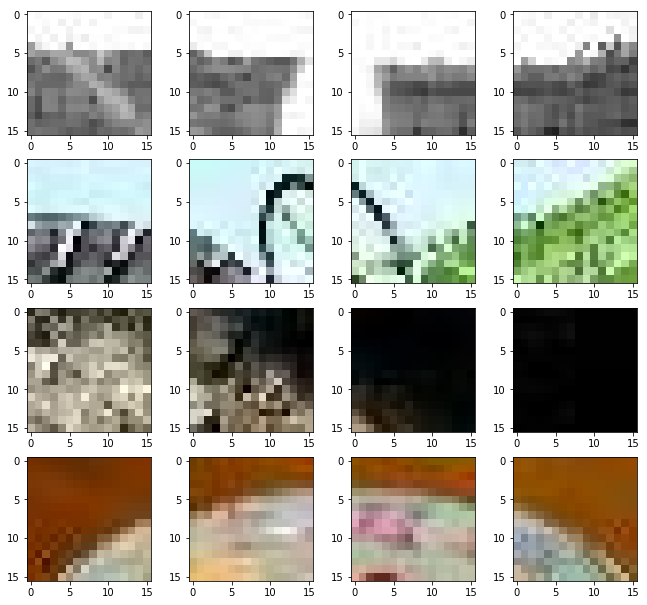

In [6]:
def print_random_patches(directory):
    patches = []
    for cat in os.listdir(directory):
        image_path = directory+'/'+cat+'/'+os.listdir(directory+'/'+cat)[0]
        temp_image = np.array(plt.imread(image_path))
        if temp_image.shape[-1] != 3:
            temp_image = np.array([temp_image,temp_image,temp_image]).transpose(1,2,0)
        patches.extend(cut_array2d(temp_image,(4,4))[:4])
    patches = np.array(patches)

    plot_portraits(patches,16,16,4,4)

print_random_patches('p3_data')

In [7]:
def flatten(images):
    image_patches = []
    for x in range(len(images)):
        temp_image = images[x]
        image_patches.extend(np.array(cut_array2d(temp_image,(4,4))))
    image_patches = np.array(image_patches)
    image_patches = image_patches.reshape((image_patches.shape[0],768))
    return image_patches
x_train_patches = flatten(x_train)
x_test_patches = flatten(x_test)

In [ ]:
def Kmeans(data,k,iteration):
    
    # randomly initialize k integers
    random_samples = random.sample(range(data.shape[1]),k)
    # initialize centroids
    centroids = data[random_samples]
    # to record the move of the centroid:
    centroid_move = []
    # dictionary to record the class of a data point
    data_classes = defaultdict(list)
    # the total iteration
    stop_at = 0
    
    for i in range(iteration):
        # array to record the amount of data of a class
        class_array = np.zeros(k)
        # array to store data points based on its class
        new_centroids = np.zeros((k,data.shape[1]))
        
        # iterate over all data points and update the new centroids
        for x in range(data.shape[0]):
            cent_class = ((centroids-data[x])**2).mean(axis=1).argmin()
            class_array[cent_class] += 1
            new_centroids[cent_class] += data[x]
        for x in range(new_centroids.shape[0]):
            if class_array[x] != 0:
                new_centroids[x] = new_centroids[x]/class_array[x]
        dist = (centroids-new_centroids).sum()
        if dist==0:
            for x in range(data.shape[0]):
                cent_class = ((centroids-data[x])**2).mean(axis=1).argmin()
                data_classes[cent_class].append(x)
            break
        # print the centroid move in every  10 iterations
        if i%10 == 0:
            move=np.sqrt((centroids-new_centroids)**2).mean()
            centroid_move.append(move)
            print("Iteration: ",i,", centroid move: ",move)
        centroids = new_centroids
        stop_at = i
    return centroids,centroid_move,stop_at,data_classes

centroids,centroid_move,stop_at,data_classes = Kmeans(x_train_patches,15,5000)

Iteration:  0 , centroid move:  53.68866928523439
Iteration:  10 , centroid move:  1.0967998993934647
Iteration:  20 , centroid move:  0.193278550644107
Iteration:  30 , centroid move:  0.09700854832666599
Iteration:  40 , centroid move:  0.060047712759093166
Iteration:  50 , centroid move:  0.0676833777995836
Iteration:  60 , centroid move:  0.04215925643301732
Iteration:  70 , centroid move:  0.02879265984721876
Iteration:  80 , centroid move:  0.06611726905255924
Iteration:  90 , centroid move:  0.09643379755131644


In [ ]:
plt.plot(centroid_move)

In [ ]:
def project_samples(sample_mean,n,eigenvectors,samples):
    centered_image = (samples-sample_mean)
    C = eigenvectors[:n]
    # shape of weights = (x,3)
    weights = np.dot(centered_image, C.T)
    return weights

In [ ]:
def PCA(samples):
    sample_mean = np.mean(samples,axis = 0)
    covariance = np.cov((samples - sample_mean).T)
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    idx = eigenvalues.argsort()[::-1]   
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx].astype(np.float64)
    eigenvectors = eigenvectors.T
    return sample_mean,eigenvalues,eigenvectors
s_m,eigenvalues,eigenvectors = PCA(x_train_patches)
weights = project_samples(s_m,3,eigenvectors,x_train_patches)

In [ ]:
def plot_dots(weights,data_classes):
    groups = []
    for x in range(6):
        temp_array = data_classes[x]
        groups.append(weights[data_classes[x]])
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111,projection='3d')
    colors = ['b','g','r','c','m','y']
    dots = zip(groups,colors)
    for weights,c in dots:
        ax.scatter(weights[:,0],weights[:,1],weights[:,2],c=c);
plot_dots(weights,data_classes)

In [ ]:
# function to plot bow histogram
def plot_histogram(weights):
    plt.figure(figsize=(5* 2, 5 * 2))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    x = np.arange(15)
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.bar(x,height=weights[i])
    return

In [ ]:
def BOW(centroids,samples):
    # should make sure the patches are categorized into the right image!
    samples = samples.reshape((int(samples.shape[0]/16),16,768))
    # matrix to store euclidean distances, needs to be transposed
    euclidean_dist = np.zeros((15,16))
    # array to store bow
    bow = []
    for x in range(samples.shape[0]):
        # iterate over centroids
        for y in range(centroids.shape[0]):
            distance_to_single_centroid = np.sqrt(((samples[x]-centroids[y])**2).sum(axis = 1))
            euclidean_dist[y] = distance_to_single_centroid
        # get the reciprocal
        r = 1/euclidean_dist.T
        # normalize
        sums = r.sum(axis=1)
        for x in range(r.shape[0]):
            r[x] = r[x]/sums[x]
        temp_bow = r.max(axis=0)
        bow.append(temp_bow)
    bow = np.array(bow)
    return bow
bow_train = BOW(centroids,x_train_patches)
bow_test = BOW(centroids,x_test_patches)

In [ ]:
def visualize_bow(y_train,bow_patches):
    categories = ['fountain','tractor','reef','banana']
    y = 0
    y_train = np.array(y_train)
    sample_index = []
    for x in range(len(y_train)):
        if y==4:
            break
        if y_train[x].split('_')[0] == categories[y]:
            sample_index.append(x)
            y+=1
    plot_histogram(bow_patches[sample_index])
visualize_bow(y_train,bow_patches)

In [ ]:
# find the distance between a sample and all training samples, and return the k nearest samples
def predict_class(k,training_dots_weights,temp_train_y,test_dot):
    nearest = []
    for x in range(training_dots_weights.shape[0]):
        temp_train = training_dots_weights[x]
        temp_dist = ((temp_train-test_dot)**2).sum()
        nearest.append(temp_dist)
    nearest = np.array(nearest)
    idx = nearest.argsort()
    temp_train_y = temp_train_y[idx]

    # current method: if no class is the majority, randomly pick one
    # further version: decrease k by one and vote again, repeat until a class is voted
    (values,counts) = np.unique(temp_train_y[:k],return_counts=True)
    ind=np.argmax(counts)
    voted_class = values[ind]
    return voted_class

In [ ]:
def k_nn(k,temp_train_x,temp_train_y,temp_test_x,temp_test_y):
    total_samples = 0
    correct_predict = 0
    temp_train_y  = np.array(temp_train_y)
    # for each sample in test set, find the distance to each sample in training set
    for x in range(temp_test_x.shape[0]):
        predicted_class = predict_class(k,temp_train_x,temp_train_y,temp_test_x[x])
#         print("predicted: ",predicted_class)
#         print("real: ",temp_valid_y[x])
        total_samples+=1
        if predicted_class.split("_")[0] == temp_test_y[x].split("_")[0]:
            correct_predict += 1
    valid_score = correct_predict/total_samples
    print(valid_score)
    return valid_score
valid_score = k_nn(5,bow_train,y_train,bow_test,y_test)